# Code to get residual brain activity after regressing out optic flow and brightness

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots
s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'

In [3]:
# get the right red/blue shades
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

In [4]:
# vid names as saved in behavioral data
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [5]:
#loading shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [6]:
# load responses (nsubs * nmovies, values 0 for "no", 1 for "yes", "9" for unsure )
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses[0,:]

array([nan,  0.,  1., nan, nan,  1.,  1.,  0.,  1.,  9.])

In [7]:
# save responses as texts with "Social", "Nonsocial" and "Neither" (so only for social v. non social comparisons) - useful for LMEs
responses_txt = []
for m in range(10):
    temp_txt = []
    temp = responses[:,m]
    for t in temp:
        if ~np.isnan(t):
            if int(t) == 1:
                temp_txt.append('Social')
            elif int(t) == 0:
                temp_txt.append('Nonsocial')
            else:
                temp_txt.append('Unsure')    
        else:
            temp_txt.append('Neither')
    responses_txt.append(temp_txt) # list of 10, each item has 1048 elements

In [9]:
suff = '_corrected'

In [14]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
tr_compensate = 1 # move TR back and low-level regs forward, change to 0 for what we had before
if vid_start_rel_tr[0]==7:
    vid_start_rel_tr -= 1 # vid_start_rel_tr stored are the first timepts AFTER t=0 (these were created for regressors originally, so without subtracting 1, each index
# we get (7, 14 etc.) was when the first nonzero regressor value was to be assigned)
# so without subtracting 1, we could potentially have been losing the earliest TR
print(vid_start_rel_tr)
l_task = 28

[6 13 13 13 13 6 13 13 13 13]


#  COAXING - BILLIARD

- We start by comparing a movie pair with comparable decision times

In [21]:
# COAX-BILL
#select subs who responded "Social" to COAXING-B and "Non-social" to BILLIARD-A
print('\nTrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm{suff}.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print(tcs_trial_z.shape)

movie_ind_yes = 0 # CHANGE MOVIE IND HERE - COAXING "Social" 
movie_ind_no = 1 # CHANGE MOVIE IND HERE - BILLIARD "Non-social"
print('"Social" movie: ' + str(vidnames[movie_ind_yes]))
print('"Non-social" movie: ' + str(vidnames[movie_ind_no]))


Trial-wise norm data.
(1049, 268, 56, 10)
"Social" movie: COAXING-B
"Non-social" movie: BILLIARD-A


<AxesSubplot:>

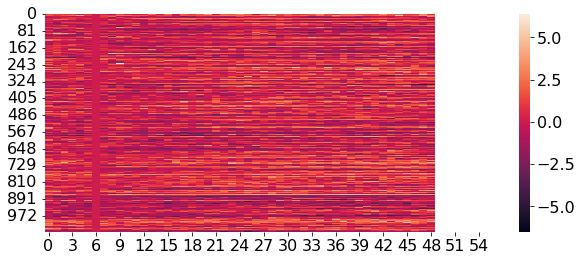

In [23]:
plt.figure(1,figsize=(10,4))
sns.heatmap(tcs_trial_z[:,0,:,0]) # the zeros (vertical band) are at TR=7, need to shift!

In [28]:
len(np.where(tcs_trial_z[:,0,vid_start_rel_tr[m],m]==0)[0])

1049

<AxesSubplot:>

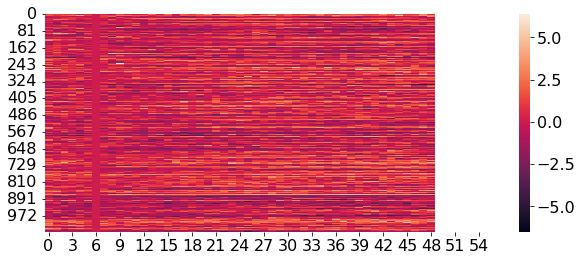

In [30]:
if tr_compensate==1: # to compensate for an error in earlier versions
    if len(np.where(tcs_trial_z[:,0,vid_start_rel_tr[m]+1,m]==0)[0]) == tcs_trial_z.shape[0]: # the baseline correction was wrt position 7 (not 6) for stim 0
        print('in')
        for s in range(tcs_trial_z.shape[0]):
            for n in range(tcs_trial_z.shape[1]):
                for m in range(10):
                    tcs_trial_z[s,n,:,m]  = tcs_trial_z[s,n,:,m] - tcs_trial_z[s,n,vid_start_rel_tr[m],m]
plt.figure(1,figsize=(10,4))
sns.heatmap(tcs_trial_z[:,0,:,0])

In [32]:
import time
from joblib import cpu_count
from pymer4.models import Lmer,Lm
from multiprocessing import Pool
from sklearn.linear_model import LinearRegression
from joblib import Parallel,delayed

[[-3.25185728e-05 -8.14525295e-02]]
[[-0.04196953 -0.04196953]]
[[-3.25185728e-05 -8.14525295e-02]]


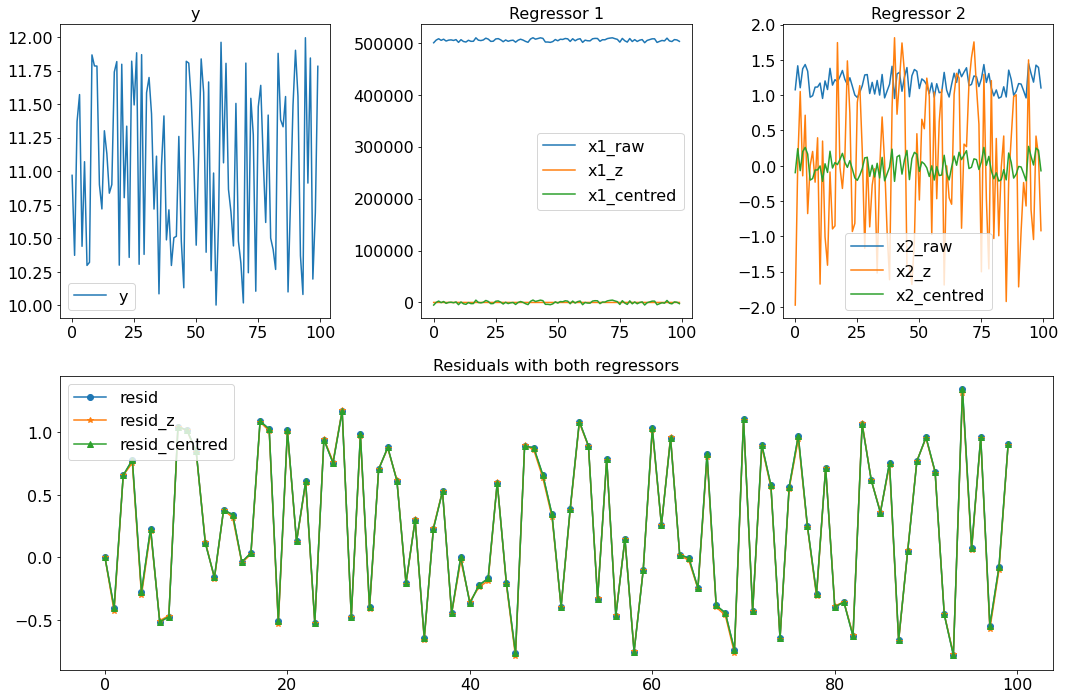

In [34]:
# playing around with different types of normalizations of the regressor

plt.figure(1,figsize=(15,10))
plt.subplot(231)
y =  np.random.rand(100,1)*2+ 10
plt.plot(y,label='y')
plt.legend()
plt.title('y')

plt.subplot(232)
x = np.random.rand(100,1)*10000+ 500000
plt.plot(x,label='x1_raw')
x_z = stats.zscore(x)
plt.plot(x_z,label='x1_z')
x_scale = x - x.mean()
plt.plot(x_scale, label='x1_centred')
plt.legend()
plt.title('Regressor 1')


plt.subplot(233)
x2 = np.random.rand(100,1)*.5+ .95
plt.plot(x2,label='x2_raw')
x2_z = stats.zscore(x)
plt.plot(x2_z,label='x2_z')
x2_scale = x2 - x2.mean()
plt.plot(x2_scale, label='x2_centred')
plt.legend()
plt.title('Regressor 2')

plt.subplot(212)
reg = np.array([x,x2]).squeeze().T
model1 = LinearRegression().fit(reg, y)
print(model1.coef_)
resid = y-model1.predict(reg)
plt.plot(resid- resid[0], marker= 'o', label = 'resid')
#print(resid_scale-resid_scale[0])

reg_z = np.array([x_z,x2_z]).squeeze().T
model2 = LinearRegression().fit(reg_z, y)
print(model2.coef_)
resid_z = y-model2.predict(reg_z)
plt.plot(resid_z-resid_z[0], marker= '*', label = 'resid_z')
#print(resid_scale-resid_scale[0])

reg_scale = np.array([x_scale,x2_scale]).squeeze().T
model3 = LinearRegression().fit(reg_scale, y)
print(model3.coef_)
resid_scale = y-model3.predict(reg_scale)
plt.plot(resid_scale-resid_scale[0],marker= '^', label = 'resid_centred')
#print(resid_scale-resid_scale[0])
plt.legend()
plt.title('Residuals with both regressors')

plt.tight_layout()

(31, 10)


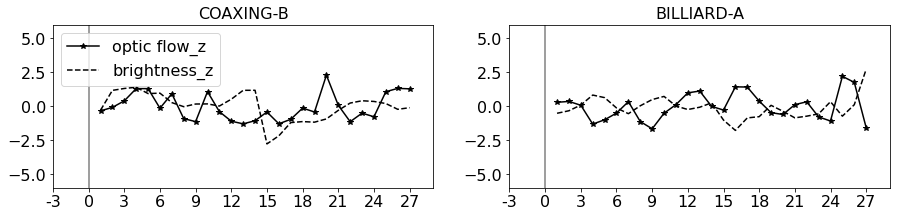

In [35]:
z_score = 1 # change to 1 to get z-scored values

# load low-level properties timecourses
if z_score==1:
    brightness_reg_1 = np.load('brightness_reg_all_z.npy')
    of_reg_1 = np.load('optic_flow_reg_all_z.npy')
else:
    brightness_reg_1 = np.load('brightness_reg_all.npy')
    of_reg_1 = np.load('optic_flow_reg_all.npy')

# if the first fmri TR is BEFORE t=0, push low-level regs to a later TR
if tr_compensate==1:
    of_reg, brightness_reg = [np.empty((31,10)) for _ in range(2)]
    of_reg[:], brightness_reg[:] = [np.nan]*2
    of_reg[1:,:] = of_reg_1[:-1,:] # shift all regressors 1 index to the right (so that optflow 0 is ). Reason: the first non-NaN value is at index 3 (4th timept)
    brightness_reg[1:,:] = brightness_reg_1[:-1,:]
else:
    of_reg,brightness_reg = of_reg_1,brightness_reg_1

print(of_reg.shape)
plt.figure(1,figsize=(15,3))
for m in range(2):
    plt.subplot(1,2,m+1)
    plt.ylim(-6,6)
    plt.plot(of_reg[:,m],color='k',label='optic flow_z',marker = '*')
    plt.plot(brightness_reg[:,m],color='k',ls='dashed', label='brightness_z')
    plt.vlines(tr0_ind,plt.ylim()[0],plt.ylim()[1],color='grey')
    plt.title(vidnames[m])
    plt.xlim(0,32)
    xticks = np.arange(0,32,3)
    plt.xticks(xticks,[str(i-tr0_ind) for i in xticks])
    if m==0:
        plt.legend()

In [38]:
#subs who respondec "Social" to COAXING-B and "Non-social" to BILLIARD-A
movie_ind_yes,movie_ind_no = 0,1
subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
nsubs = np.where(subs)[0].shape[0]
subs.shape, nsubs

((870,), 870)

In [63]:
def return_residuals(df,plotfig =0):
    # df: rows: ranging from tr-14 or the earliest TR to TR+28+14, columns: 0: BOLD, 1: optic flow, 2: brightness
    # plotfig: 1(plot) or 0(don't plot)
    # returns: residuals of the same dimension as nr of rows in df
    
    rows = ~(np.isnan(df[:,0])) & ~(np.isnan(df[:,1])) & ~(np.isnan(df[:,2]))
    total_len = df.shape[0]
    if len(np.where(rows)[0]) != total_len: # if NaN is present
        df_nonan = df[rows,:]
        y,regs = df_nonan[:,0],df_nonan[:,1:]
    else:
        y,regs = df[:,0],df[:,1:]

    try:
        model = LinearRegression().fit(regs, y)
        resid = y - model.predict(regs)
    
        if plotfig:
            plt.plot(df[:,0],label='raw TC')
            plt.plot(df[:,1],label='optflow',color='grey')
            plt.plot(df[:,2],label='brightness',color='grey',ls='dashed')
            plt.plot(resid,label = 'residual TC1')
            plt.legend(bbox_to_anchor=[1.01,1])
    except:
        resid = np.empty((df.shape[0],))
        resid[:] = np.nan
    return resid

In [71]:
# take a long time, look through before running!!!!
load_resid_coaxbill = 0 # 1: load residuals, 0: compute residuals
if load_resid_coaxbill == 0:
    resid_tc = np.empty((tcs_trial_z.shape[0],268,31,2)) #subs, nodes, timepts, movies
    resid_tc[:] = np.nan
    start_time = time.time()
    parallelise = 0
    for s in np.arange(tcs_trial_z.shape[0]):
        if (s%20 == 0) and (s!=0):
            print(s, f'time elapsed: {(time.time()-start_time)/60:.2f}')
        for m in range(2):
            df = []
            for n in range(268):
                if  m%5 == 0:
                    y = tcs_trial_z[s,n,:49,m]
                else:
                    y = tcs_trial_z[s,n,:,m]
                df.append(np.array([y,reg_all[m][:,0],reg_all[m][:,1]]).T)

            if parallelise:
                residuals_ = Parallel(n_jobs=10)(delayed(return_residuals)(y) for y in df)  # pool.map(return_residuals,df_coax) 
            else:
                residuals_ = []
                for n in range(268):
                    residuals_.append(return_residuals(df[n]))                 

            tmin,tmax = vid_start_rel_tr[m]-tr0_ind,vid_start_rel_tr[m]+28
            for n in range(268):
                res_n = residuals_[n][tmin:tmax]
                res_n -= res_n[tr0_ind]
                resid_tc[s,n,:,m] = res_n
    if tr_compensate==1:
        np.save(os.path.join(data_file_loc,'residuals_tc_z_trialwise_earlyTR.npy'),resid_tc)
    else:
        np.save(os.path.join(data_file_loc,'residuals_tc_z_trialwise_lateTR.npy'),resid_tc)
else:
    if tr_compensate==1:
        resid_tc = np.load(os.path.join(data_file_loc,'residuals_tc_z_trialwise_earlyTR.npy'))
    else:
        resid_tc = np.load(os.path.join(data_file_loc,'residuals_tc_z_trialwise_lateTR.npy'))

20 time elapsed: 0.06
40 time elapsed: 0.12
60 time elapsed: 0.17
80 time elapsed: 0.24
100 time elapsed: 0.30
120 time elapsed: 0.36
140 time elapsed: 0.42
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
160 time elapsed: 0.50
180 time elapsed

## Plotting some nodes

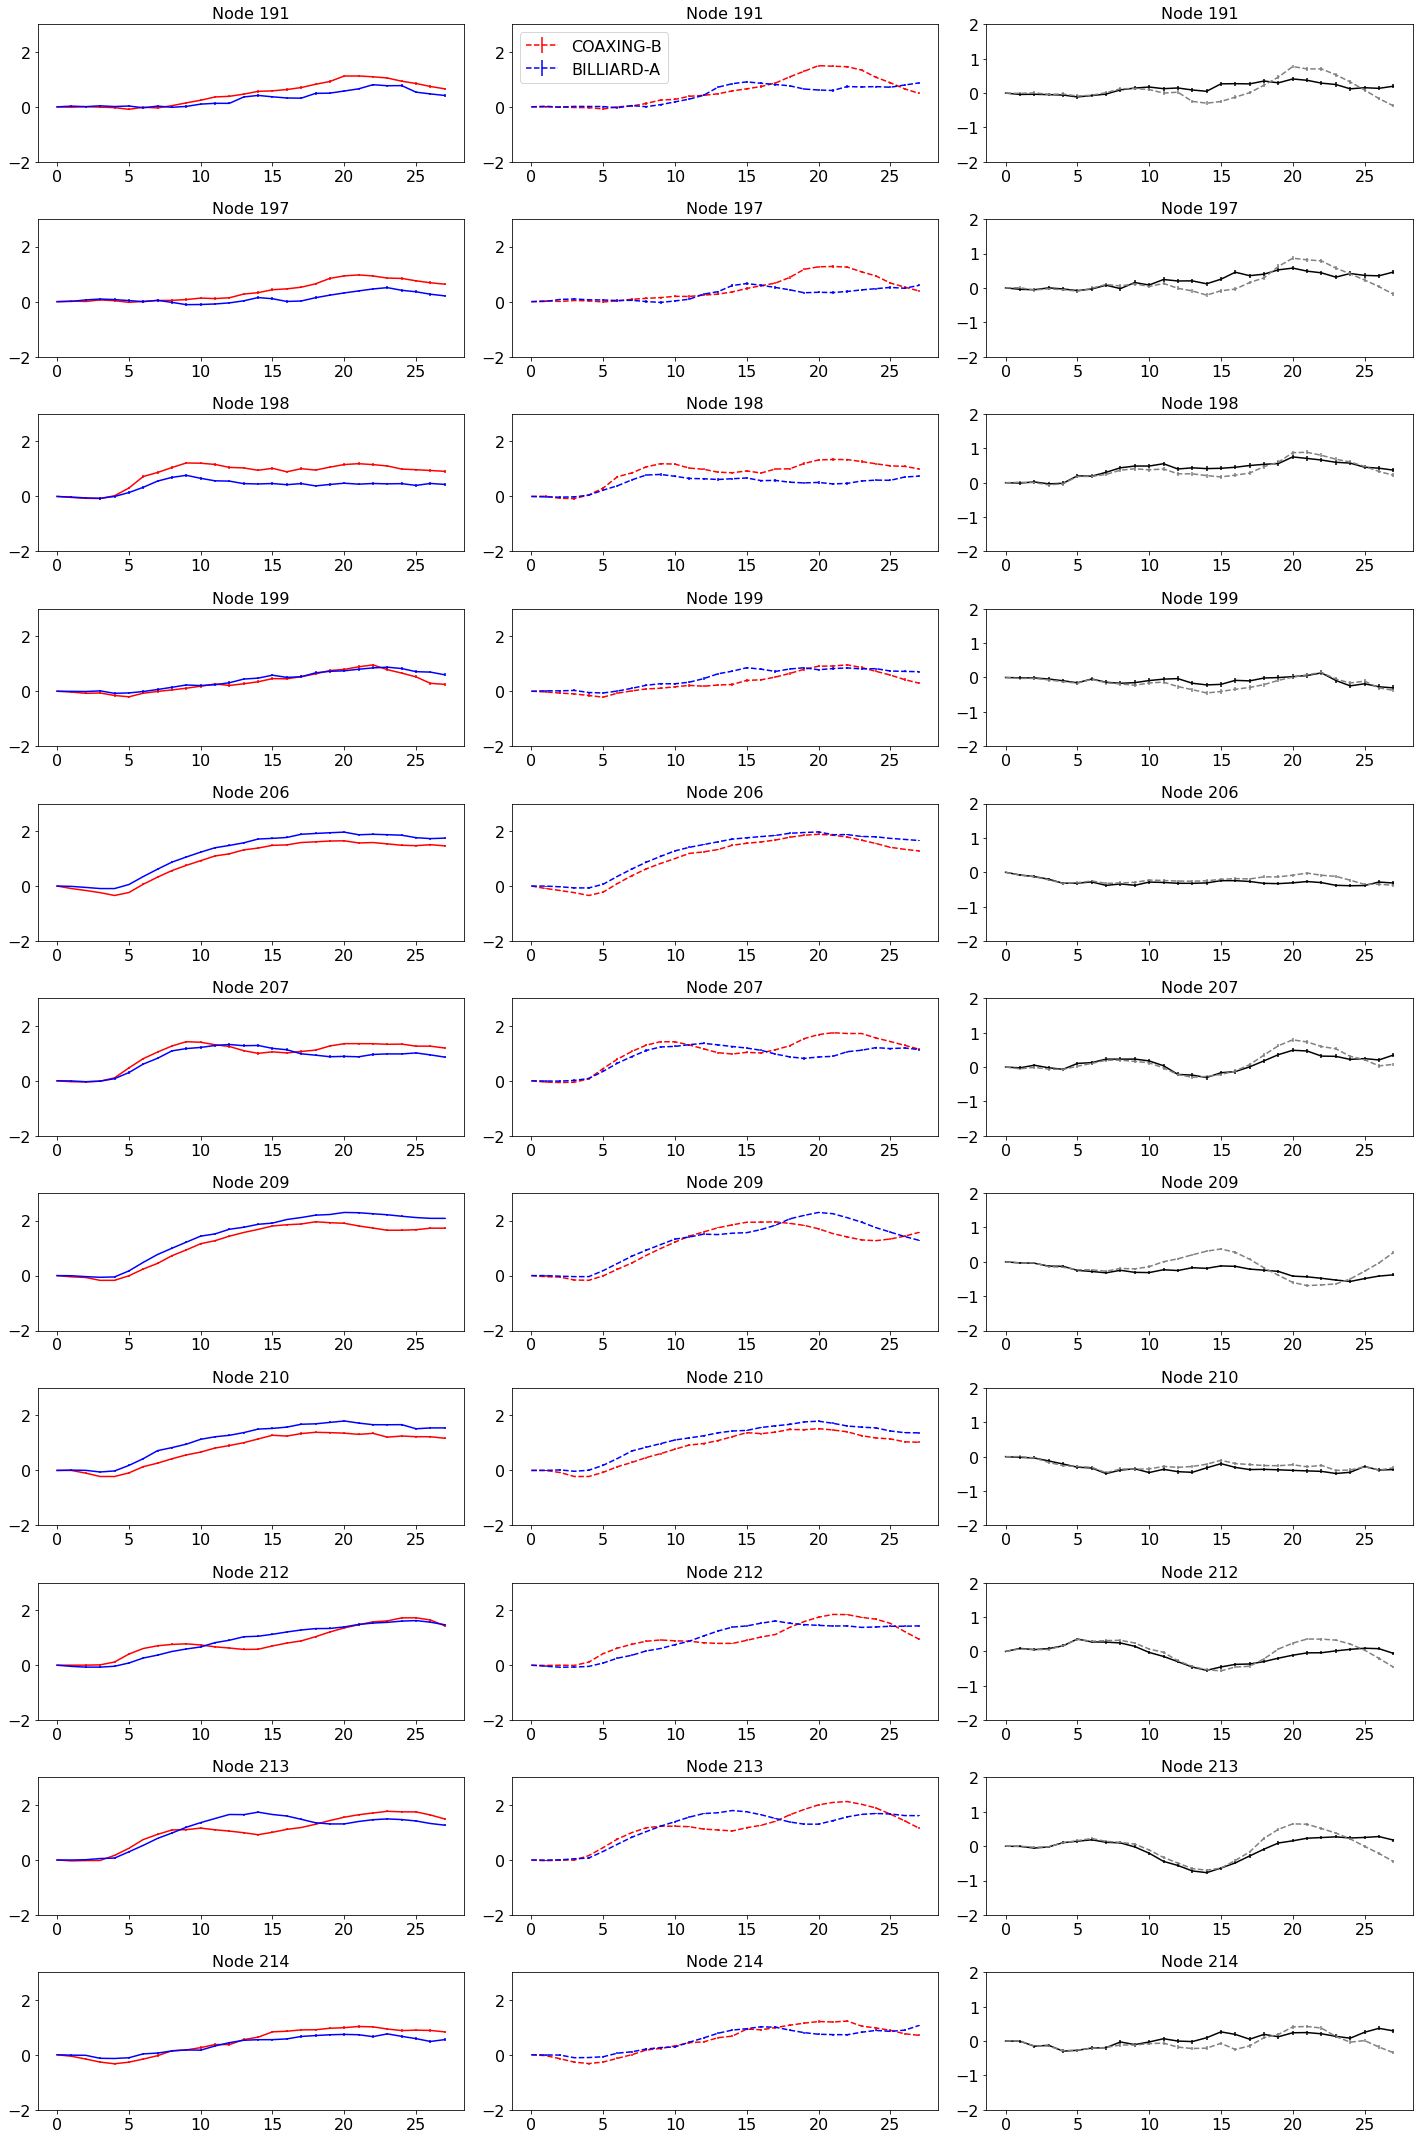

In [97]:
# left hemisphere nodes
plt.figure(1,figsize=(20,30))
ncols = 3
for i,n in enumerate([190,196,197,198,205,206,208,209,211,212,213]):#df_minus10_0_right['Nodes'].values):
    plt.subplot(11,ncols,i*ncols+1)
    col = ['r','b']
    plt.title('Node ' + str(n+1))
    for m in range(2):
        tc = tcs_trial_z[subs,n,vid_start_rel_tr[m]:vid_start_rel_tr[m]+28,m]
        plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0,nan_policy='omit'),color=col[m],label=vidnames[m])
    plt.ylim(-2,3)
        
    plt.subplot(11,ncols,i*ncols+2) # residual timecourses
    plt.title('Node ' + str(n+1))
    for m in range(2):
        tc_res = resid_tc[:,n,tr0_ind:,m]
        plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0,nan_policy='omit'),color=col[m],ls='dashed',label = vidnames[m])
        
    if i==0:
        plt.legend()#bbox_to_anchor=[1.01,1])
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+3) # S-NS difference in tc
    col = 'k'
    plt.title('Node ' + str(n+1))
    tc_diff = tcs_trial_z[subs,n,vid_start_rel_tr[0]:vid_start_rel_tr[0]+28,0] - tcs_trial_z[subs,n,vid_start_rel_tr[1]:vid_start_rel_tr[1]+28,1]
    plt.errorbar(range(28),np.nanmedian(tc_diff,axis=0),stats.sem(tc_diff,axis=0,nan_policy='omit'),color=col,label=f'{vidnames[1]}-\n{vidnames[0]}')
    plt.ylim(-2,2)

    plt.subplot(11,ncols,i*ncols+3)
    col = 'grey'
    plt.title('Node ' + str(n+1))
    resid_diff = resid_tc[:,n,tr0_ind:,0] - resid_tc[:,n,tr0_ind:,1]
    plt.errorbar(range(28),np.nanmedian(resid_diff,axis=0),stats.sem(resid_diff,axis=0,nan_policy='omit'),color=col,ls='--')#,label=f'{vidnames[1]}-\n{vidnames[0]}')
    #plt.legend()
    plt.ylim(-2,2)
    
plt.tight_layout()

# not sorted early to late.

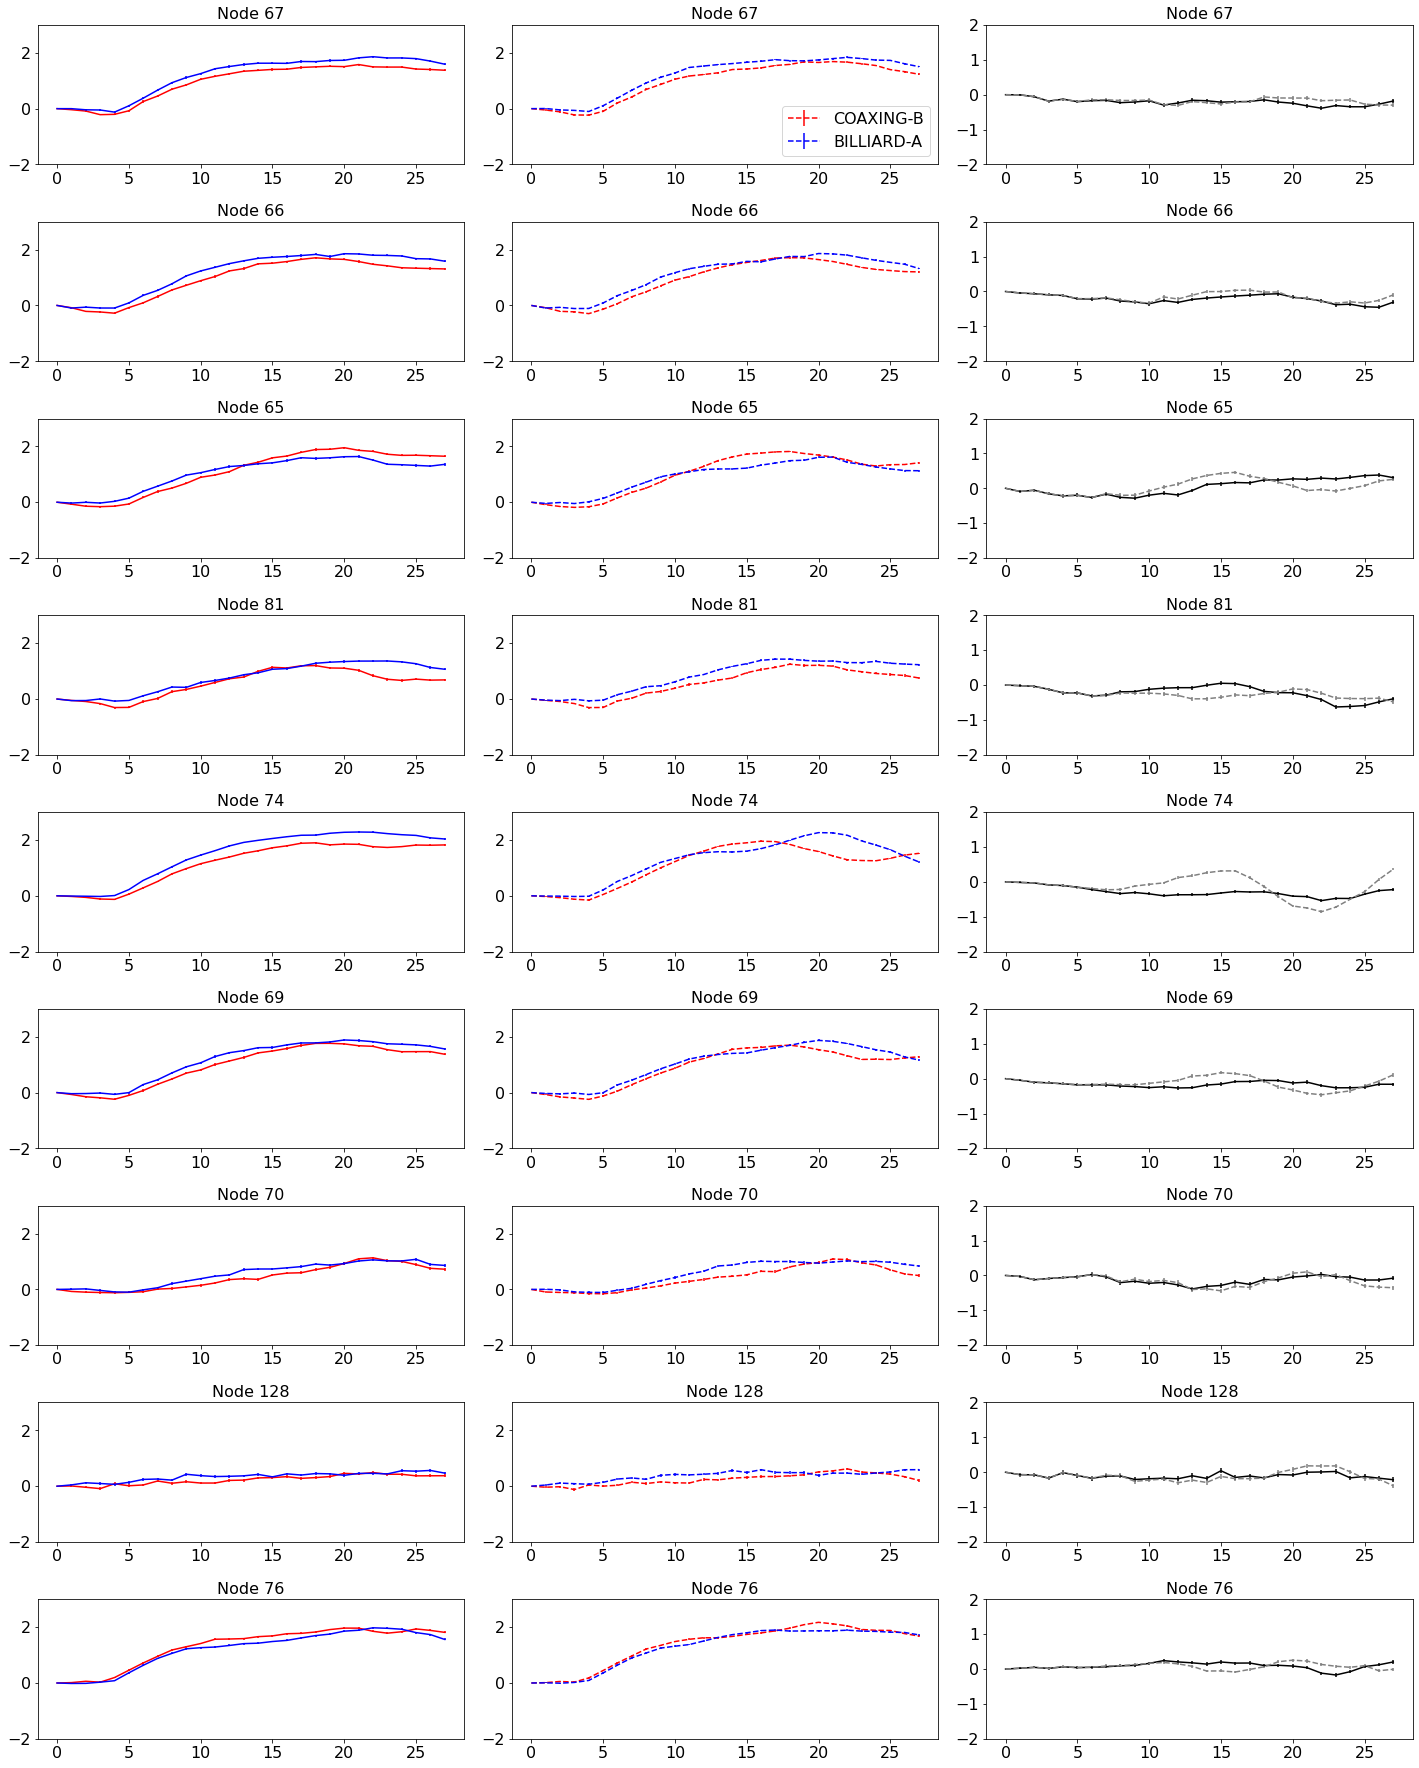

In [100]:
# right hemisphere nodes
plt.figure(1,figsize=(20,30))
ncols = 3
for i,n in enumerate([66,65,64,80,73,68,69,127,75]):#df_minus10_0_right['Nodes'].values):
    #n = 65
    plt.subplot(11,ncols,i*ncols+1)
    col = ['r','b']
    plt.title('Node ' + str(n+1))
    for m in range(2):
        tc = tcs_trial_z[subs,n,vid_start_rel_tr[m]:vid_start_rel_tr[m]+28,m] #tcs_trial_z[subs,n,tr0_ind:,m]
        plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0,nan_policy='omit'),color=col[m],label=vidnames[m])
    plt.ylim(-2,3)
        
    plt.subplot(11,ncols,i*ncols+2)
    plt.title('Node ' + str(n+1))
    for m in range(2):
        tc_res = resid_tc[:,n,tr0_ind:,m]
        plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0,nan_policy='omit'),color=col[m],ls='dashed',label = vidnames[m])
        
    if i==0:
        plt.legend()#bbox_to_anchor=[1.01,1])
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+3)
    col = 'k'
    plt.title('Node ' + str(n+1))
    tc_diff = tcs_trial_z[subs,n,vid_start_rel_tr[0]:vid_start_rel_tr[0]+28,0] - tcs_trial_z[subs,n,vid_start_rel_tr[1]:vid_start_rel_tr[1]+28,1]
    plt.errorbar(range(28),np.nanmedian(tc_diff,axis=0),stats.sem(tc_diff,axis=0,nan_policy='omit'),color=col,label=f'{vidnames[1]}-\n{vidnames[0]}')

    plt.subplot(11,ncols,i*ncols+3)
    col = 'grey'
    plt.title('Node ' + str(n+1))
    resid_diff = resid_tc[subs,n,tr0_ind:,0] - resid_tc[subs,n,tr0_ind:,1]
    plt.errorbar(range(28),np.nanmedian(resid_diff,axis=0),stats.sem(resid_diff,axis=0,nan_policy='omit'),color=col,ls='--')#,label=f'{vidnames[1]}-\n{vidnames[0]}')
    plt.ylim(-2,2)
    
plt.tight_layout()
# not sorted early to late.